In [1]:

import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub,plot_line
from util.consts import QueueEvent
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt

In [17]:
dir_input="/data2/lichenni/path_perflow_link"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
for shard in np.arange(2000):
    for n_flows in [2000]:
        for key_tag in [21]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{key_tag}_")+"s%d_i0"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{key_tag}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                
                stats = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                flow_size_dist=stats.item().get("size_dist_candidate")
                max_load=float(stats.item().get("load_bottleneck_target"))
                key_tag=flow_size_dist
                # if max_load<0.45:
                #     key_tag='load=[20%,45%)'
                # elif max_load<0.65:
                #     key_tag='load=[45%,65%)'
                # elif max_load<0.85:
                #     key_tag='load=[65%,85%)'
                # else:
                #     key_tag='load=[85%,95%)'
                
                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid)%n_flows==0:
                    data_list.append((spec,topo_type_cur,key_tag))
                else:
                    print(f"fid not valid: {spec}")
print(f"len(data_list): {len(data_list)}")

fid not valid: shard1_nflows2000_nhosts21_lr10Gbps
fid not valid: shard5_nflows2000_nhosts21_lr10Gbps
fid not valid: shard55_nflows2000_nhosts21_lr10Gbps
fid not valid: shard441_nflows2000_nhosts21_lr10Gbps
fid not valid: shard688_nflows2000_nhosts21_lr10Gbps
fid not valid: shard840_nflows2000_nhosts21_lr10Gbps
fid not valid: shard1080_nflows2000_nhosts21_lr10Gbps
fid not valid: shard1104_nflows2000_nhosts21_lr10Gbps
fid not valid: shard1483_nflows2000_nhosts21_lr10Gbps
fid not valid: shard1599_nflows2000_nhosts21_lr10Gbps
fid not valid: shard1738_nflows2000_nhosts21_lr10Gbps
len(data_list): 1989


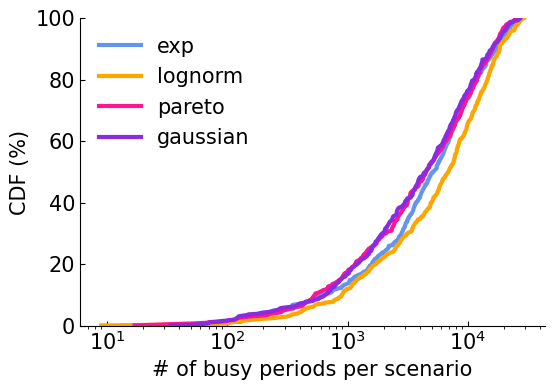

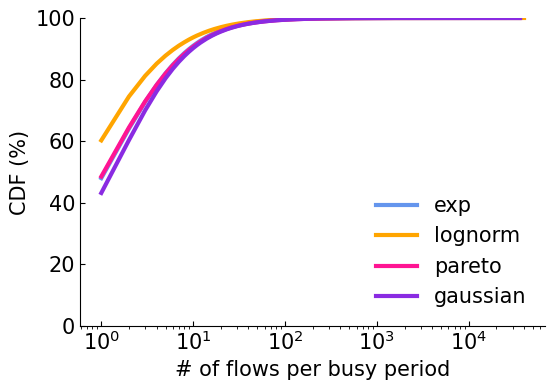

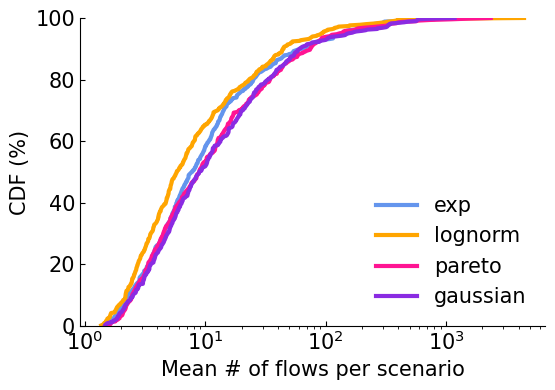

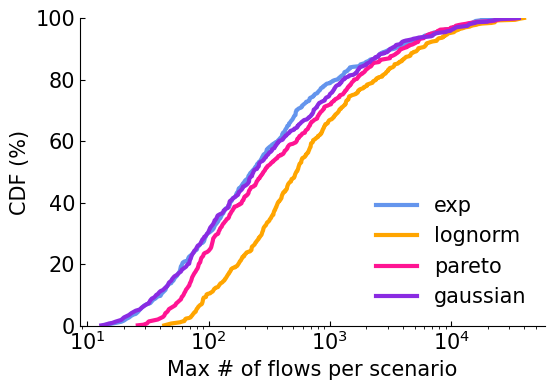

In [18]:
num_period_all=defaultdict(list)
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
for spec_idx,(spec,topo_type,key_tag) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    busy_periods=np.load(f'{input_tmp}/period{topo_type}.npy', allow_pickle=True)
    
    num_period_all[key_tag].append(len(busy_periods))
    
    len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
    len_per_period_all[key_tag].extend(len_per_period)
    len_per_period_all_mean[key_tag].append(len_per_period.mean())
    len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'{key_tag}' for key_tag in len_per_period_all.keys()]

plot_data=[np.array(num_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of busy periods per scenario',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

In [4]:
dir_input="/data2/lichenni/path_perflow_link_empirical"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
for shard in np.arange(1000):
    for n_flows in [2000]:
        for key_tag in [21]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{key_tag}_")+"s%d_i0"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{key_tag}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                
                stats = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                flow_size_dist=stats.item().get("size_dist_candidate")
                max_load=float(stats.item().get("load_bottleneck_target"))
                # key_tag=flow_size_dist
                if max_load<0.45:
                    key_tag='load=[20%,45%)'
                elif max_load<0.65:
                    key_tag='load=[45%,65%)'
                elif max_load<0.85:
                    key_tag='load=[65%,85%)'
                else:
                    key_tag='load=[85%,95%)'
                
                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid)%n_flows==0:
                    data_list.append((spec,topo_type_cur,key_tag))
                else:
                    print(f"fid not valid: {spec}")
print(f"len(data_list): {len(data_list)}")

len(data_list): 1000


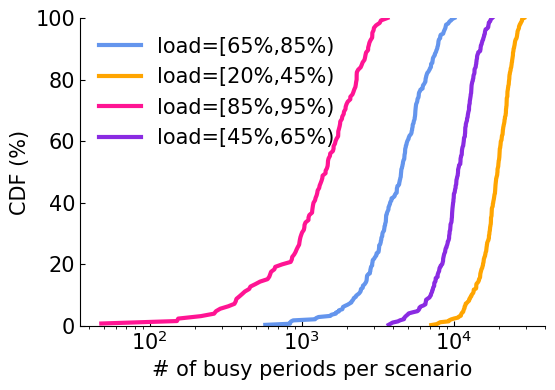

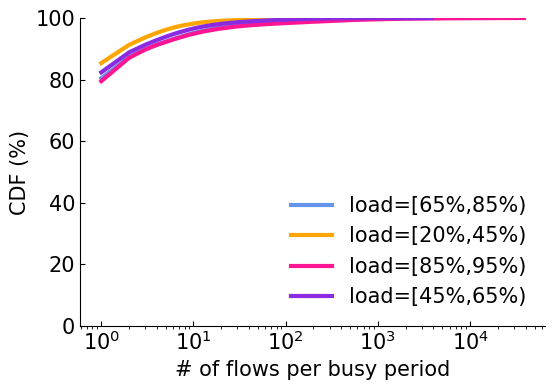

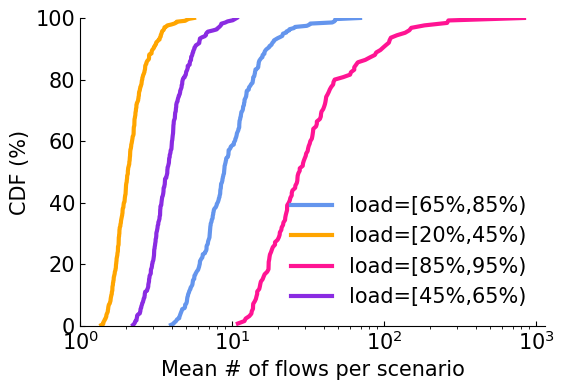

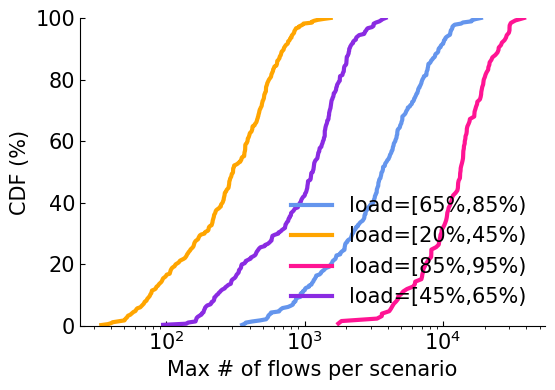

In [5]:
num_period_all=defaultdict(list)
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
for spec_idx,(spec,topo_type,key_tag) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    busy_periods=np.load(f'{input_tmp}/period{topo_type}.npy', allow_pickle=True)
    
    num_period_all[key_tag].append(len(busy_periods))
    
    len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
    len_per_period_all[key_tag].extend(len_per_period)
    len_per_period_all_mean[key_tag].append(len_per_period.mean())
    len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'{key_tag}' for key_tag in len_per_period_all.keys()]

plot_data=[np.array(num_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of busy periods per scenario',legend_font=15,group_size=len(legend_list),loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

In [9]:
dir_input="/data2/lichenni/path_perflow_empirical"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
for shard in np.arange(200):
# for shard in np.random.choice(2000,100,replace=False):
# for shard in [534]:
    for n_flows in [2000]:
        for key_tag in [3,5,7]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{key_tag}_")+"s%d_i0"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{key_tag}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid)%n_flows==0:
                    data_list.append((spec,topo_type_cur,key_tag))
                else:
                    print(f"fid not valid: {spec}")
print(f"len(data_list): {len(data_list)}")

len(data_list): 600


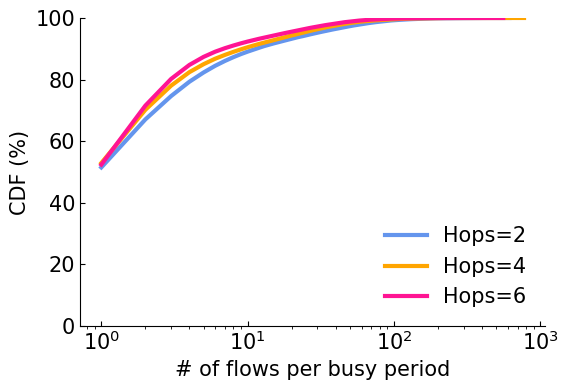

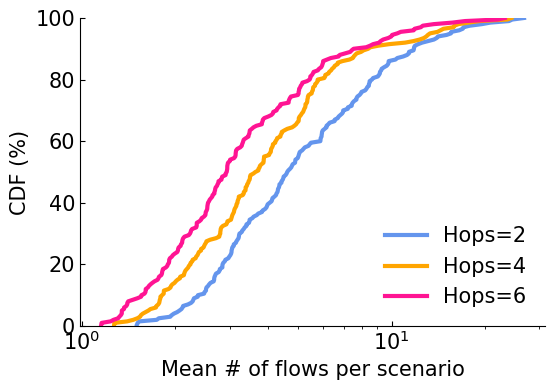

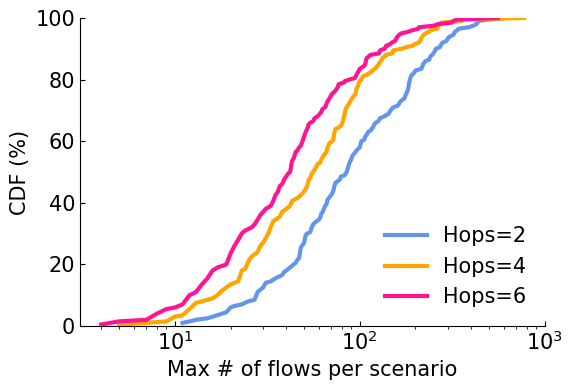

In [10]:
len_per_period_all=defaultdict(list)
len_per_period_all_mean=defaultdict(list)
len_per_period_all_max=defaultdict(list)
for spec_idx,(spec,topo_type,key_tag) in enumerate(data_list):
    input_tmp=f"{dir_input}/{spec}"
    # Read the log file
    busy_periods=np.load(f'{input_tmp}/period{topo_type}.npy', allow_pickle=True)
    # len_per_period = np.array([len(period) for period in busy_periods])
    len_per_period = np.array([int(period[1])-int(period[0])+1 for period in busy_periods])
    len_per_period_all[key_tag].extend(len_per_period)
    len_per_period_all_mean[key_tag].append(len_per_period.mean())
    len_per_period_all_max[key_tag].append(len_per_period.max())

legend_list=[f'Hops={key_tag-1}' for key_tag in len_per_period_all.keys()]
plot_data=[np.array(len_per_period_all[key_tag]) for key_tag in len_per_period_all.keys()]
fig_idx=0
plot_cdf(plot_data,None,legend_list,f'# of flows per busy period',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_mean[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Mean # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

plot_data=[np.array(len_per_period_all_max[key_tag]) for key_tag in len_per_period_all.keys()]
plot_cdf(plot_data,None,legend_list,f'Max # of flows per scenario',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)
fig_idx+=1

        